# Assignment 2

## Machine Learning 1

**Utkarsh Thusoo**  
**M20AIE318**

### Custom Naive Baye's class

In [1]:
import numpy as np
import pandas as pd


class CustomGNB:

    def __init__(self, priors=None):
        """
        Init operation for the CustomGNB class
        :param priors: Will be the prior probabilities
        """
        self.priors = priors
        self.training_mean_dict = dict()
        self.training_stddev_dict = dict()

    def fit1(self, features, classes):
        """
        Fitness functions which calculates mean, standard deviation and priors for the provided dataset

        :param features: Features of dataset
        :param classes: Classes for each of that feature
        :return: null
        """
        temp_dict = self.init_dict(features, classes)
        self.training_mean_dict = self.compute_mean(temp_dict)
        self.training_stddev_dict = self.compute_sd(temp_dict, self.training_mean_dict)
        self.priors = self.compute_prior(features, classes)

    def fit(self, training_features, training_classes, testing_features, testing_classes):
        """
        Fitness functions which calculates mean, standard deviation and priors for the provided dataset
        :param training_features: Features of training dataset
        :param training_classes: Classes for each of that feature in training dataset
        :param testing_features: Features of testing dataset
        :param testing_classes: Classes for each of that feature in testing dataset
        :return: null
        """
        temp_dict = self.init_dict(training_features, training_classes)
        self.training_mean_dict = self.compute_mean(temp_dict)
        self.training_stddev_dict = self.compute_sd(temp_dict, self.training_mean_dict)
        total_data = np.vstack((training_features, testing_features))
        total_predictions = np.concatenate([training_classes, testing_classes])
        self.priors = self.compute_prior(total_data, total_predictions)

    @staticmethod
    def init_dict(training, prediction):
        """
        Inititalizes a dictionary with key as each class and value as the row provided

        :param training: training data
        :param prediction: training predictions
        :return:
        """
        temp_dict = dict()
        index = 0
        for each in prediction:
            if each in temp_dict:
                dict_list = temp_dict[each]
                temp_dict[each] = np.vstack((dict_list, training[index]))
            else:
                temp_dict[each] = training[index]
            index = index + 1

        return temp_dict

    @staticmethod
    def compute_mean(temp_dict):
        """
        Computes the mean of the dataset

        :param temp_dict: dictionary
        :return: dictionary with key as classes and value as mean feature array
        """
        mean_dict = {}

        for each in temp_dict:
            arr = temp_dict[each].sum(axis=0) / len(temp_dict[each])
            mean_dict[each] = arr

        return mean_dict

    @staticmethod
    def compute_sd(temp_dict, mean_dict):
        """
        Computes the standard deviation for dataset

        :param temp_dict: dictionary
        :param mean_dict: dictionary with key as classes and value as mean feature array
        :return: dictionary with key as classes and value as standard deviation feature array
        """
        std_dev_dict = {}

        for each in temp_dict:
            mean_list = mean_dict[each]
            index = 0

            for row in temp_dict[each]:
                if each in std_dev_dict:
                    new_row = (row - mean_list) ** 2
                    std_dev_dict[each] = np.add(new_row, std_dev_dict[each])
                else:
                    std_dev_dict[each] = (row - mean_list) ** 2

            arr = np.sqrt(std_dev_dict[each] / len(temp_dict[each]))
            std_dev_dict[each] = arr

        return std_dev_dict

    def compute_prior(self, features, classes):
        """
        Computes the priors for the features and class provided

        :param features: Features provided
        :param classes: Classes provided
        :return: dictionary with key as classes and value as prior values for that class
        """
        prior_dict = dict()

        if self.priors is None:
            temp_dict = self.init_dict(features, classes)

            for each in sorted(temp_dict.keys()):
                prior_dict[each] = len(temp_dict[each]) / len(features)
        else:
            prior_dict = self.priors

        return prior_dict

    def predict(self, features):
        """
        Performs predictions for the features provided

        :param features: Feature array
        :return: prediction array
        """
        index = 0
        enumeration_dict = self.compute_enumeration(self.priors)
        prediction = np.empty(len(features), dtype=object)
        for _test in features:
            temp_arr = np.empty(len(self.priors), dtype=object)
            posterior_prob = self.compute_posterior_probability(_test)
            _max = 0
            for _class in posterior_prob:
                probability = posterior_prob[_class]
                temp_arr[enumeration_dict[_class]] = probability
                if _max < probability:
                    _max = probability
                    prediction[index] = _class

            index = index + 1

        return prediction

    def predict_prob(self, features):
        """
        Computes the probabilities for each of the feature provided in the dataset based based on each class.
        :param features:
        :return: probability array
        """
        probabilities = []
        for _test in features:
            probability_values = []
            for class_val, sample in self.compute_posterior_probability(_test).items():
                probability_values.append(sample)
            probabilities.append(probability_values)

        return np.array(probabilities)

    def compute_posterior_probability(self, row, classes=None):
        """
        Computues posterior probability for each feature.
        P(class|data) = P(X|class) * P(class) / marginal probability
        :param row: Array containing features
        :param classes: prior probabiities for each class
        :return: dictionary with key as classes and value as posterior probability
        """
        if classes is None:
            classes = self.priors

        class_conditional_dict = dict()
        posterior_prob = dict()

        total_marginal_probability = 0
        for each in classes.keys():
            mean_arr = self.training_mean_dict[each]
            stddev_arr = self.training_stddev_dict[each]

            numerator = ((row - mean_arr) ** 2) * -1
            denominator = 2 * (stddev_arr ** 2)

            exponent = np.exp(numerator / denominator)
            ## Formulae:  N(x; µ, σ) = (1 / 2πσ) * (e ^ (x–µ)^2/-2σ^2
            gaussian_pdf = (1 / (np.sqrt(2 * np.pi * stddev_arr))) * exponent
            class_conditional_dict[each] = np.prod(gaussian_pdf) * self.priors[each]
            total_marginal_probability = total_marginal_probability + class_conditional_dict[each]

        for each in class_conditional_dict:
            posterior_prob[each] = class_conditional_dict[each] / total_marginal_probability

        return posterior_prob

    @staticmethod
    def compute_enumeration(classes):
        """
        Computes a dictionary with key as class name and value as the index from 0 to N(number of classes)
        :param classes: Class list
        :return: dictionary with key-value pair where key is class name and value as the index
        """
        enumeration_dict = dict()
        index = 0

        for each in sorted(classes.keys()):
            enumeration_dict[each] = index
            index = index + 1

        return enumeration_dict

    def print_values(self, header, values):
        if isinstance(values, np.ndarray):
            print('\033[1m%s: \033[0m' % header)

            for each in range(0, len(self.priors)):
                if isinstance(values[each], np.float64):
                    print("Class %d: %f" % (each, values[each]))
                elif isinstance(values[each], np.int64):
                    print("Class %d: %d" % (each, values[each]))
        else:
            print('\033[1m%s: \033[0m %s' % (header, values))

    def compute_confusion_matrix(self, predictions, actual):
        """
        Computes confusion matrix
        :param predictions: predictions
        :param actual: actual values
        :return: NXN confusion matrix
        """
        enumeration_dict = self.compute_enumeration(self.priors)

        confusion_matrix = np.zeros([len(self.priors.keys()), len(self.priors.keys())], dtype=int)
        index = 0
        for each in actual:
            i = enumeration_dict[each]
            j = enumeration_dict[predictions[index]]
            np.add.at(confusion_matrix[i], j, 1)
            index = index + 1

        print('\033[1m' + 'Confusion Matrix:' + '\033[0m')
        print(confusion_matrix)
        return confusion_matrix

    @staticmethod
    def accuracy(predicted_classes, actual_classes):
        index = 0
        for each in actual_classes:
            print("Class %s - %s" % (predicted_classes[index], actual_classes[each]))
            index = index + 1

    def compute_stats(self, confusion_matrix):
        self.print_values("Priors", self.priors)
        self.print_values("Mean", self.training_mean_dict)
        self.print_values("Standard Deviation", self.training_stddev_dict)
        variance = dict()
        for each in self.training_stddev_dict:
            variance[each] = self.training_stddev_dict[each] ** 2
        self.print_values("Variance", variance)

        total_class = len(self.priors.keys())
        self.print_values("Total Classes", total_class)

        classes = self.compute_enumeration(self.priors).keys()
        self.print_values("Enumerations", classes)

        temp_dict = {}
        actual_cases = np.sum(confusion_matrix, axis=1)
        temp_dict['Actual Cases'] = actual_cases

        predicted_cases = np.sum(confusion_matrix, axis=0)
        temp_dict['Predicted Cases'] = predicted_cases

        fn_cases = np.zeros([total_class], dtype=int)
        tp_cases = np.zeros([total_class], dtype=int)

        for row in range(0, total_class):
            _sum = 0
            for column in range(0, total_class):
                if row == column:
                    tp_cases[row] = confusion_matrix[row][column]
                    continue
                _sum = _sum + confusion_matrix[row][column]
            fn_cases[row] = _sum

        temp_dict['FN'] = fn_cases
        temp_dict['TP'] = tp_cases

        fp_cases = predicted_cases - tp_cases
        temp_dict['FP'] = fp_cases

        tn_cases = actual_cases.sum() - (actual_cases + fn_cases)
        temp_dict['TN'] = tn_cases

        tnr = tn_cases / (fp_cases + tn_cases)
        temp_dict['TNR'] = tnr

        tpr = tp_cases / (fn_cases + tp_cases)
        temp_dict['TPR'] = tpr

        fpr = fp_cases / (tn_cases + fp_cases)
        temp_dict['FPR'] = fpr

        fnr = fn_cases / (fn_cases + tp_cases)
        temp_dict['FNR'] = fnr

        accuracy = (tpr + tnr) / 2
        temp_dict['Accuracy'] = accuracy * 100

        overall_accuracy = tp_cases.sum() / actual_cases.sum()
        self.print_values("Accuracy", overall_accuracy * 100)

        stats_df = pd.DataFrame(temp_dict, index=classes)
        stats_df.style.set_properties(**{'text-align': 'right'})
        return stats_df


#### Q1. Classification using Naive Bayes classifier. Apply Naive bayes classifier assuming all features are independent. Do not use any predefined library for classification. Report overall accuracy, class wise accuracy, confusion matrix and ROC curve.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from CustomGNB import CustomGNB

df = pd.read_csv("Iris.csv")
X = df.iloc[:, 1:5].values
Y = df.Species.to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=0)

obj = CustomGNB()
obj.fit(X_train, Y_train, X_test, Y_test)
enumeration_dict = obj.compute_enumeration(obj.priors)
predicted_features = obj.predict(X_test)
confusion_matrix = obj.compute_confusion_matrix(predicted_features, Y_test)
obj.compute_stats(confusion_matrix)

Confusion Matrix:
[[16  0  0]
 [ 0 18  0]
 [ 0  0 11]]
Priors:  {'Iris-setosa': 0.3333333333333333, 'Iris-versicolor': 0.3333333333333333, 'Iris-virginica': 0.3333333333333333}
Mean:  {'Iris-versicolor': array([5.921875, 2.75625 , 4.196875, 1.30625 ]), 'Iris-virginica': array([6.65384615, 2.98717949, 5.5974359 , 2.03076923]), 'Iris-setosa': array([4.99411765, 3.38235294, 1.45294118, 0.22941176])}
Standard Deviation:  {'Iris-versicolor': array([0.53017354, 0.33997932, 0.48378997, 0.20453835]), 'Iris-virginica': array([0.65274417, 0.34654299, 0.56044267, 0.25934221]), 'Iris-setosa': array([0.35475027, 0.3914307 , 0.14190986, 0.09557692])}
Variance:  {'Iris-versicolor': array([0.28108398, 0.11558594, 0.23405273, 0.04183594]), 'Iris-virginica': array([0.42607495, 0.12009204, 0.31409599, 0.06725838]), 'Iris-setosa': array([0.12584775, 0.15321799, 0.02013841, 0.00913495])}
Total Classes:  3
Enumerations:  dict_keys(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])
Accuracy:  100.0


,Actual Cases,Predicted Cases,FN,TP,FP,TN,TNR,TPR,FPR,FNR,Accuracy
Iris-setosa,16,16,0,16,0,29,1.0,1.0,0.0,0.0,100.0
Iris-versicolor,18,18,0,18,0,27,1.0,1.0,0.0,0.0,100.0
Iris-virginica,11,11,0,11,0,34,1.0,1.0,0.0,0.0,100.0


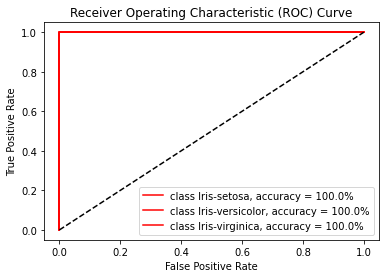

In [3]:
label_binaries = LabelBinarizer()
y_binaries = label_binaries.fit_transform(Y_test)
prob_scores = obj.predict_prob(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
auc_val = dict()
index = 0
for each in enumeration_dict:
    fpr[index], tpr[index], _ = roc_curve(y_binaries[:, index], prob_scores[:, index])
    roc_auc = auc(fpr[index], tpr[index])
    auc_val[index] = roc_auc_score(y_binaries[:, index], prob_scores[:, index])
    plt.plot(fpr[index], tpr[index], color='Red',
             label='class ' + each + ', accuracy = ' + str(round(auc_val[index], 10) * 100) + '%')
    index = index + 1

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


#### Shuffle the data with seed value 42 and perform a 70- 30 stratified split of the data into a train and test set. Also, plot the class-wise distribution of data in the train and test set (one for train set and one for test set). Compare the distributions. 

#### (a) Train a Gaussian Naive Bayes classifier and report (a) the class priors, (b) mean and variance of each feature per class.

#### Computing Stats for Test Wine data

In [4]:
from CustomGNB import CustomGNB
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

wine_data = load_wine()
X = wine_data.data
y = wine_data.target_names[wine_data.target]

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

obj1 = CustomGNB()
obj1.fit1(X_train, Y_train)

prediction = obj1.predict(X_test)
cf_matrix = obj1.compute_confusion_matrix(prediction, Y_test)
obj1.compute_stats(cf_matrix)

Confusion Matrix:
[[17  1  0]
 [ 0 21  0]
 [ 0  0 15]]
Priors:  {'class_0': 0.33064516129032256, 'class_1': 0.4032258064516129, 'class_2': 0.2661290322580645}
Mean:  {'class_0': array([1.37304878e+01, 1.94707317e+00, 2.44975610e+00, 1.71024390e+01,
       1.06634146e+02, 2.82853659e+00, 2.94024390e+00, 3.01707317e-01,
       1.85121951e+00, 5.56780488e+00, 1.05097561e+00, 3.08853659e+00,
       1.11280488e+03]), 'class_1': array([1.22424e+01, 1.96260e+00, 2.23280e+00, 2.05240e+01, 9.51400e+01,
       2.25360e+00, 2.04680e+00, 3.50800e-01, 1.71220e+00, 2.96080e+00,
       1.05892e+00, 2.80220e+00, 5.31260e+02]), 'class_2': array([1.30745455e+01, 3.20090909e+00, 2.45424242e+00, 2.15606061e+01,
       9.92727273e+01, 1.68757576e+00, 7.87575758e-01, 4.46363636e-01,
       1.13878788e+00, 7.36272724e+00, 6.73030303e-01, 1.69060606e+00,
       6.24393939e+02])}
Standard Deviation:  {'class_0': array([4.50500812e-01, 6.29096309e-01, 2.46165598e-01, 2.70099239e+00,
       1.07833569e+01, 3.389

,Actual Cases,Predicted Cases,FN,TP,FP,TN,TNR,TPR,FPR,FNR,Accuracy
class_0,18,17,1,17,0,35,1.000000,0.944444,0.000000,0.055556,97.222222
class_1,21,22,0,21,1,33,0.970588,1.000000,0.029412,0.000000,98.529412
class_2,15,15,0,15,0,39,1.000000,1.000000,0.000000,0.000000,100.000000


#### Computing Stats for Training Wine data

In [5]:
prediction = obj1.predict(X_train)
cf_matrix = obj1.compute_confusion_matrix(Y_train, prediction)
obj1.compute_stats(cf_matrix)

Confusion Matrix:
[[39  0  0]
 [ 2 49  0]
 [ 0  1 33]]
Priors:  {'class_0': 0.33064516129032256, 'class_1': 0.4032258064516129, 'class_2': 0.2661290322580645}
Mean:  {'class_0': array([1.37304878e+01, 1.94707317e+00, 2.44975610e+00, 1.71024390e+01,
       1.06634146e+02, 2.82853659e+00, 2.94024390e+00, 3.01707317e-01,
       1.85121951e+00, 5.56780488e+00, 1.05097561e+00, 3.08853659e+00,
       1.11280488e+03]), 'class_1': array([1.22424e+01, 1.96260e+00, 2.23280e+00, 2.05240e+01, 9.51400e+01,
       2.25360e+00, 2.04680e+00, 3.50800e-01, 1.71220e+00, 2.96080e+00,
       1.05892e+00, 2.80220e+00, 5.31260e+02]), 'class_2': array([1.30745455e+01, 3.20090909e+00, 2.45424242e+00, 2.15606061e+01,
       9.92727273e+01, 1.68757576e+00, 7.87575758e-01, 4.46363636e-01,
       1.13878788e+00, 7.36272724e+00, 6.73030303e-01, 1.69060606e+00,
       6.24393939e+02])}
Standard Deviation:  {'class_0': array([4.50500812e-01, 6.29096309e-01, 2.46165598e-01, 2.70099239e+00,
       1.07833569e+01, 3.389

,Actual Cases,Predicted Cases,FN,TP,FP,TN,TNR,TPR,FPR,FNR,Accuracy
class_0,39,41,0,39,2,85,0.977011,1.000000,0.022989,0.000000,98.850575
class_1,51,50,2,49,1,71,0.986111,0.960784,0.013889,0.039216,97.344771
class_2,34,33,1,33,0,89,1.000000,0.970588,0.000000,0.029412,98.529412


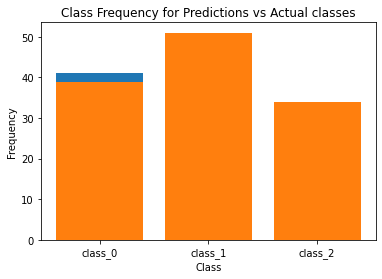

In [6]:
unique, counts = np.unique(Y_train, return_counts=True)
plt.bar(unique, counts)
unique, counts = np.unique(prediction, return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency for Predictions vs Actual classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

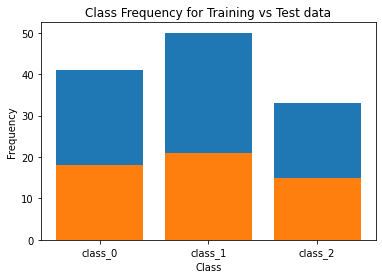

In [7]:
unique, counts = np.unique(Y_train, return_counts=True)
plt.bar(unique, counts)
unique, counts = np.unique(Y_test, return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency for Training vs Test data')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

#### Train another Gaussian Naive Bayes classifier by setting prior probability for the classes. Repeat this experiment by setting priors in the ratios:
#### (a) 40-40-20

#### Ans

Totat data: 178  
Total Training Data: 40+40+20=100  
Marginal probability = 1.78  
Rows from each class_0: 1.78 * 40 ~ 71  
Rows from each class_1: 1.78 * 40 ~ 71  
Rows from each class_2: 1.78 * 20 ~ 36  

Probability for class_0 = 71/178 ~ 0.39887640449438202247191011235955  
Probability for class_1 = 71/178 ~ 0.39887640449438202247191011235955  
Probability for class_2 = 36/178 ~ 0.2022471910112359550561797752809

#### Computing Stats for Test Wine data

In [8]:
priors = {'class_0': 0.39, 'class_1': 0.39, 'class_2': 0.20}
obj2 = CustomGNB(priors)
obj2.fit1(X_train, Y_train)

prediction = obj2.predict(X_test)
cf_matrix = obj2.compute_confusion_matrix(prediction, Y_test)
obj2.compute_stats(cf_matrix)

Confusion Matrix:
[[17  1  0]
 [ 0 21  0]
 [ 0  0 15]]
Priors:  {'class_0': 0.39, 'class_1': 0.39, 'class_2': 0.2}
Mean:  {'class_0': array([1.37304878e+01, 1.94707317e+00, 2.44975610e+00, 1.71024390e+01,
       1.06634146e+02, 2.82853659e+00, 2.94024390e+00, 3.01707317e-01,
       1.85121951e+00, 5.56780488e+00, 1.05097561e+00, 3.08853659e+00,
       1.11280488e+03]), 'class_1': array([1.22424e+01, 1.96260e+00, 2.23280e+00, 2.05240e+01, 9.51400e+01,
       2.25360e+00, 2.04680e+00, 3.50800e-01, 1.71220e+00, 2.96080e+00,
       1.05892e+00, 2.80220e+00, 5.31260e+02]), 'class_2': array([1.30745455e+01, 3.20090909e+00, 2.45424242e+00, 2.15606061e+01,
       9.92727273e+01, 1.68757576e+00, 7.87575758e-01, 4.46363636e-01,
       1.13878788e+00, 7.36272724e+00, 6.73030303e-01, 1.69060606e+00,
       6.24393939e+02])}
Standard Deviation:  {'class_0': array([4.50500812e-01, 6.29096309e-01, 2.46165598e-01, 2.70099239e+00,
       1.07833569e+01, 3.38940681e-01, 3.70980821e-01, 7.34482542e-02,
 

,Actual Cases,Predicted Cases,FN,TP,FP,TN,TNR,TPR,FPR,FNR,Accuracy
class_0,18,17,1,17,0,35,1.000000,0.944444,0.000000,0.055556,97.222222
class_1,21,22,0,21,1,33,0.970588,1.000000,0.029412,0.000000,98.529412
class_2,15,15,0,15,0,39,1.000000,1.000000,0.000000,0.000000,100.000000


#### Computing Stats for Training Wine data

In [9]:
prediction = obj2.predict(X_train)
cf_matrix = obj2.compute_confusion_matrix(Y_train, prediction)
obj2.compute_stats(cf_matrix)

Confusion Matrix:
[[39  0  0]
 [ 2 49  0]
 [ 0  1 33]]
Priors:  {'class_0': 0.39, 'class_1': 0.39, 'class_2': 0.2}
Mean:  {'class_0': array([1.37304878e+01, 1.94707317e+00, 2.44975610e+00, 1.71024390e+01,
       1.06634146e+02, 2.82853659e+00, 2.94024390e+00, 3.01707317e-01,
       1.85121951e+00, 5.56780488e+00, 1.05097561e+00, 3.08853659e+00,
       1.11280488e+03]), 'class_1': array([1.22424e+01, 1.96260e+00, 2.23280e+00, 2.05240e+01, 9.51400e+01,
       2.25360e+00, 2.04680e+00, 3.50800e-01, 1.71220e+00, 2.96080e+00,
       1.05892e+00, 2.80220e+00, 5.31260e+02]), 'class_2': array([1.30745455e+01, 3.20090909e+00, 2.45424242e+00, 2.15606061e+01,
       9.92727273e+01, 1.68757576e+00, 7.87575758e-01, 4.46363636e-01,
       1.13878788e+00, 7.36272724e+00, 6.73030303e-01, 1.69060606e+00,
       6.24393939e+02])}
Standard Deviation:  {'class_0': array([4.50500812e-01, 6.29096309e-01, 2.46165598e-01, 2.70099239e+00,
       1.07833569e+01, 3.38940681e-01, 3.70980821e-01, 7.34482542e-02,
 

,Actual Cases,Predicted Cases,FN,TP,FP,TN,TNR,TPR,FPR,FNR,Accuracy
class_0,39,41,0,39,2,85,0.977011,1.000000,0.022989,0.000000,98.850575
class_1,51,50,2,49,1,71,0.986111,0.960784,0.013889,0.039216,97.344771
class_2,34,33,1,33,0,89,1.000000,0.970588,0.000000,0.029412,98.529412


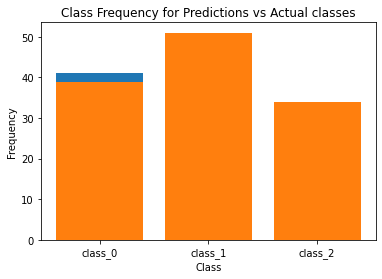

In [10]:
unique, counts = np.unique(Y_train, return_counts=True)
plt.bar(unique, counts)
unique, counts = np.unique(prediction, return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency for Predictions vs Actual classes')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

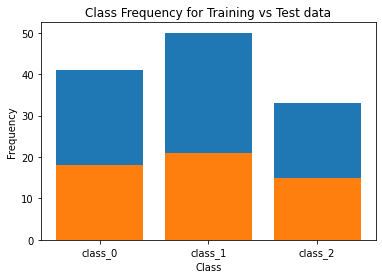

In [11]:
unique, counts = np.unique(Y_train, return_counts=True)
plt.bar(unique, counts)
unique, counts = np.unique(Y_test, return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency for Training vs Test data')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

#### Train another Gaussian Naive Bayes classifier by setting prior probability for the classes. Repeat this experiment by setting priors in the ratios:
#### (b) 80-10-10.

#### Ans

Totat data: 178   
Total Training Data: 80+10+10=100  
Marginal probability = 1.78  
Rows from each class_0: 1.78 * 80 ~ 142  
Rows from each class_1: 1.78 * 10 ~ 18  
Rows from each class_2: 1.78 * 10 ~ 18  

Probability for class_0 = 142/178 ~ 0.39887640449438202247191011235955  
Probability for class_1 = 18/178 ~ 0.39887640449438202247191011235955  
Probability for class_2 = 18/178 ~ 0.2022471910112359550561797752809

#### Computing Stats for Test Wine data

In [17]:
priors = {'class_0': 0.79, 'class_1': 0.10, 'class_2': 0.10}
obj3 = CustomGNB(priors)
obj3.fit1(X_train, Y_train)

prediction = obj3.predict(X_test)
cf_matrix = obj3.compute_confusion_matrix(prediction, Y_test)
obj3.compute_stats(cf_matrix)

Confusion Matrix:
[[17  1  0]
 [ 0 21  0]
 [ 0  0 15]]
Priors:  {'class_0': 0.1, 'class_1': 0.1, 'class_2': 0.1}
Mean:  {'class_0': array([1.37304878e+01, 1.94707317e+00, 2.44975610e+00, 1.71024390e+01,
       1.06634146e+02, 2.82853659e+00, 2.94024390e+00, 3.01707317e-01,
       1.85121951e+00, 5.56780488e+00, 1.05097561e+00, 3.08853659e+00,
       1.11280488e+03]), 'class_1': array([1.22424e+01, 1.96260e+00, 2.23280e+00, 2.05240e+01, 9.51400e+01,
       2.25360e+00, 2.04680e+00, 3.50800e-01, 1.71220e+00, 2.96080e+00,
       1.05892e+00, 2.80220e+00, 5.31260e+02]), 'class_2': array([1.30745455e+01, 3.20090909e+00, 2.45424242e+00, 2.15606061e+01,
       9.92727273e+01, 1.68757576e+00, 7.87575758e-01, 4.46363636e-01,
       1.13878788e+00, 7.36272724e+00, 6.73030303e-01, 1.69060606e+00,
       6.24393939e+02])}
Standard Deviation:  {'class_0': array([4.50500812e-01, 6.29096309e-01, 2.46165598e-01, 2.70099239e+00,
       1.07833569e+01, 3.38940681e-01, 3.70980821e-01, 7.34482542e-02,
   

,Actual Cases,Predicted Cases,FN,TP,FP,TN,TNR,TPR,FPR,FNR,Accuracy
class_0,18,17,1,17,0,35,1.000000,0.944444,0.000000,0.055556,97.222222
class_1,21,22,0,21,1,33,0.970588,1.000000,0.029412,0.000000,98.529412
class_2,15,15,0,15,0,39,1.000000,1.000000,0.000000,0.000000,100.000000


#### Computing Stats for Training Wine data

In [13]:
prediction = obj3.predict(X_train)
cf_matrix = obj3.compute_confusion_matrix(Y_train, prediction)
obj3.compute_stats(cf_matrix)

Confusion Matrix:
[[39  0  0]
 [ 2 49  0]
 [ 0  1 33]]
Priors:  {'class_0': 0.79, 'class_1': 0.1, 'class_2': 0.1}
Mean:  {'class_0': array([1.37304878e+01, 1.94707317e+00, 2.44975610e+00, 1.71024390e+01,
       1.06634146e+02, 2.82853659e+00, 2.94024390e+00, 3.01707317e-01,
       1.85121951e+00, 5.56780488e+00, 1.05097561e+00, 3.08853659e+00,
       1.11280488e+03]), 'class_1': array([1.22424e+01, 1.96260e+00, 2.23280e+00, 2.05240e+01, 9.51400e+01,
       2.25360e+00, 2.04680e+00, 3.50800e-01, 1.71220e+00, 2.96080e+00,
       1.05892e+00, 2.80220e+00, 5.31260e+02]), 'class_2': array([1.30745455e+01, 3.20090909e+00, 2.45424242e+00, 2.15606061e+01,
       9.92727273e+01, 1.68757576e+00, 7.87575758e-01, 4.46363636e-01,
       1.13878788e+00, 7.36272724e+00, 6.73030303e-01, 1.69060606e+00,
       6.24393939e+02])}
Standard Deviation:  {'class_0': array([4.50500812e-01, 6.29096309e-01, 2.46165598e-01, 2.70099239e+00,
       1.07833569e+01, 3.38940681e-01, 3.70980821e-01, 7.34482542e-02,
  

,Actual Cases,Predicted Cases,FN,TP,FP,TN,TNR,TPR,FPR,FNR,Accuracy
class_0,39,41,0,39,2,85,0.977011,1.000000,0.022989,0.000000,98.850575
class_1,51,50,2,49,1,71,0.986111,0.960784,0.013889,0.039216,97.344771
class_2,34,33,1,33,0,89,1.000000,0.970588,0.000000,0.029412,98.529412


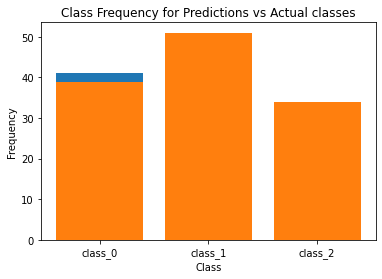

In [14]:
unique, counts = np.unique(Y_train, return_counts=True)
plt.bar(unique, counts)
unique, counts = np.unique(prediction, return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency for Predictions vs Actual classes')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

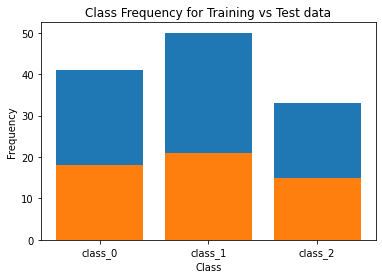

In [15]:
unique, counts = np.unique(Y_train, return_counts=True)
plt.bar(unique, counts)
unique, counts = np.unique(Y_test, return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency for Training vs Test data')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

### Observation
#### There is no significant difference when we change the priors